![UKDS Logo](images/UKDS_Logos_Col_Grey_300dpi.png)

# Text-mining: Extracting Named Entities and Creating Social Networks

Welcome to the <a href="https://ukdataservice.ac.uk/" target=_blank>UK Data Service</a> training series on *New Forms of Data for Social Science Research*. This series guides you through some of the most common and valuable new sources of data available for social science research: data collected from websites, social media platorms, text data, conducting simulations (agent based modelling), to name a few. We provide webinars, interactive notebooks containing live programming code, reading lists and more.

* To access training materials for the entire series: <a href="https://github.com/UKDataServiceOpen/new-forms-of-data" target=_blank>[Training Materials]</a>

* To keep up to date with upcoming and past training events: <a href="https://ukdataservice.ac.uk/news-and-events/events" target=_blank>[Events]</a>

* To get in contact with feedback, ideas or to seek assistance: <a href="https://ukdataservice.ac.uk/help.aspx" target=_blank>[Help]</a>

<a href="https://www.research.manchester.ac.uk/portal/julia.kasmire.html" target=_blank>Dr Julia Kasmire</a> and <a href="https://www.research.manchester.ac.uk/portal/diarmuid.mcdonnell.html" target=_blank>Dr Diarmuid McDonnell</a> <br />
UK Data Service  <br />
University of Manchester <br />
May 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Acquire-and-prepare-a-set-of-documents-with-named-entities." data-toc-modified-id="Acquire-and-prepare-a-set-of-documents-with-named-entities.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Acquire and prepare a set of documents with named entities.</a></span></li><li><span><a href="#Extract-the-desired-chunks" data-toc-modified-id="Extract-the-desired-chunks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract the desired chunks</a></span></li><li><span><a href="#Identify-which-extracted-proper-nouns-are-named-in-the-same-document" data-toc-modified-id="Identify-which-extracted-proper-nouns-are-named-in-the-same-document-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Identify which extracted proper nouns are named in the same document</a></span></li><li><span><a href="#Create-a-network-graph-and-add-the-nodes" data-toc-modified-id="Create-a-network-graph-and-add-the-nodes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create a network graph and add the nodes</a></span></li><li><span><a href="#Add-edges-to-the-network-graph" data-toc-modified-id="Add-edges-to-the-network-graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Add edges to the network graph</a></span></li><li><span><a href="#Have-a-look-at-graph-info" data-toc-modified-id="Have-a-look-at-graph-info-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Have a look at graph info</a></span></li><li><span><a href="#Draw-the-graph" data-toc-modified-id="Draw-the-graph-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Draw the graph</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Further-reading" data-toc-modified-id="Further-reading-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Further reading</a></span></li></ul></div>


There is a table of contents provided here at the top of the notebook, but you can also access this menu at any point by clicking the Table of Contents button on the top toolbar (an icon with four horizontal bars, if unsure hover your mouse over the buttons). 

## Introduction

We already saw how to add part-of-speech tags and named entity labels to a corpus, but now we will explore a practical applications for those POS-tags and entity labels - extracted the names of people and creating a social network based on which people are mentioned in the same document. 

There are, of course, many other very useful and practical applications for POS-tags and/or entity labels. However, as always, readers should interpret this notebook as being a demonstration of a popular option rather than an exhaustive or comprehensive guide to all possibilities.

## Acquire and prepare a set of documents with named entities.

As always, let's start by importing and downloading some useful packages. Many of these will be familiar to you if you have worked through the 'Basic Extraction' notebook, but there are always some new tools to explore. 

Run/Shift+Enter.

In [1]:
import nltk                                          # get nltk 
from nltk import word_tokenize, pos_tag, ne_chunk    # import some of our old favourte functions

from nltk import Tree                                # and import some new functions
from itertools import chain, tee
!pip install networkx
from operator import itemgetter
import networkx as nx                                # Just notice this line for now... We will refer to it again later.
from networkx.algorithms import community
import matplotlib.pyplot as plt

In [2]:
social_data = ['Archibald walked through Manchester with Beryl.', 
               'Tariq saw Beryl when she was playing tennis.', 
               'Archibald shares a house with Beryl and Cerys.',
               'Cerys works with both Tariq and Edith.', 
               'Edith drives past Archibald and Denise on her morning commute.',
               'Fadwa listens to podcasts while running.', 
               'Guo-feng and Hita often drive to the Welsh coast at weekends.',
               'Icarus shops at the same supermarket as Janyu and Edith.', 
               'Kelsey and Edith both used to live in London.',
               'Laia and Icarus are on the same bowling team.', 
               'Archibald and Kelsey are both keen gardeners.',
               'Laia and Montserrat are both Catalonians. '
              ]

In [3]:
print(social_data
     )

['Archibald walked through Manchester with Beryl.', 'Tariq saw Beryl when she was playing tennis.', 'Archibald shares a house with Beryl and Cerys.', 'Cerys works with both Tariq and Edith.', 'Edith drives past Archibald and Denise on her morning commute.', 'Fadwa listens to podcasts while running.', 'Guo-feng and Hita often drive to the Welsh coast at weekends.', 'Icarus shops at the same supermarket as Janyu and Edith.', 'Kelsey and Edith both used to live in London.', 'Laia and Icarus are on the same bowling team.', 'Archibald and Kelsey are both keen gardeners.', 'Laia and Montserrat are both Catalonians. ']


Named Entity chunkers require data that is:
* word tokenised and 
* POS-tagged. 

Named Entity chunkers return a list of nested trees. 

In [4]:
tagged_chunked_data = []
for item in social_data:
    tokens = word_tokenize(item)
    tags = nltk.pos_tag(tokens)
    chunks = ne_chunk(tags)
    tagged_chunked_data.append(chunks)
    
print(tagged_chunked_data)                       # print everything, since this is a small enough list

[Tree('S', [Tree('PERSON', [('Archibald', 'NNP')]), ('walked', 'VBD'), ('through', 'IN'), ('Manchester', 'NNP'), ('with', 'IN'), Tree('PERSON', [('Beryl', 'NNP')]), ('.', '.')]), Tree('S', [Tree('PERSON', [('Tariq', 'NNP')]), ('saw', 'VBD'), Tree('PERSON', [('Beryl', 'NNP')]), ('when', 'WRB'), ('she', 'PRP'), ('was', 'VBD'), ('playing', 'VBG'), ('tennis', 'NN'), ('.', '.')]), Tree('S', [Tree('GPE', [('Archibald', 'NNP')]), ('shares', 'NNS'), ('a', 'DT'), ('house', 'NN'), ('with', 'IN'), Tree('PERSON', [('Beryl', 'NNP')]), ('and', 'CC'), Tree('PERSON', [('Cerys', 'NNP')]), ('.', '.')]), Tree('S', [Tree('GPE', [('Cerys', 'NNP')]), ('works', 'VBZ'), ('with', 'IN'), ('both', 'DT'), Tree('PERSON', [('Tariq', 'NNP')]), ('and', 'CC'), Tree('PERSON', [('Edith', 'NNP')]), ('.', '.')]), Tree('S', [Tree('GPE', [('Edith', 'NNP')]), ('drives', 'NNS'), ('past', 'JJ'), Tree('ORGANIZATION', [('Archibald', 'NNP')]), ('and', 'CC'), Tree('PERSON', [('Denise', 'NNP')]), ('on', 'IN'), ('her', 'PRP$'), ('mo

Looking at the results, we can see that each item in the list is a tree because each sentence starts with a "Tree('S')" indicating that the highest level of tree is a Sentence Tree. 

But Sentence Trees can have sub-trees. Each sub-tree also starts with "Tree('TREE_TYPE')" and we can see that there are "Tree('PERSON')", "Tree('ORGANISATION')" and "Tree('GPE')". Unfortunately, the ne_chunker is not perfect. 'Edith' is listed as a 'GPE' in one place but a 'PERSON' in another. Likewise, 'Archibald' is both a 'PERSON' and an 'ORGANISATION', while 'Guo-feng' and 'Montserrat' are not identified as sub-trees at all. You can probably find more mis-classifications. 

Let's take a closer look at those sentences. Run/Shift+Enter.

In [7]:
print(tagged_chunked_data[5])


(S
  (GPE Fadwa/NNP)
  listens/VBZ
  to/TO
  podcasts/NNS
  while/IN
  running/VBG
  ./.)


Feel free to change the number in the above code block and re-run it to look at other sentences. 

Ultimately, a NER chunker is a classifier and can be trained on custom data as we have already seen how to do (check the classifier jupyter notebook in the same folder as this one!). 

Feel free to try training your own NER chunker classifier. You'll need to put social_data through a word_tokenisation process, then use its output to create a training data set. Then train a classifier on your training data set. 

But for now, we carry on!

## Extract the desired chunks

Now that we have some reasonable chunks all chunked up nicely, we want to extract the desired chunks so that they can become the nodes in our network. 

Run/Shift+Enter!

In [8]:
extracted_persons = []
for tagged_tree in tagged_chunked_data:
    people = []
    for leaf in tagged_tree.leaves():
        if 'NNP' in leaf[1]:
            people.append(leaf[0])        
    extracted_persons.append(sorted(people))
    
print(extracted_persons)

[['Archibald', 'Beryl', 'Manchester'], ['Beryl', 'Tariq'], ['Archibald', 'Beryl', 'Cerys'], ['Cerys', 'Edith', 'Tariq'], ['Archibald', 'Denise', 'Edith'], ['Fadwa'], ['Guo-feng', 'Hita', 'Welsh'], ['Edith', 'Icarus', 'Janyu'], ['Edith', 'Kelsey', 'London'], ['Icarus', 'Laia'], ['Archibald', 'Kelsey'], ['Catalonians', 'Laia', 'Montserrat']]


Have a look at the results of the code above. It is a list of lists. Each of the sub-lists contains all the nouns that occur in a given sentence. For example, the first sentence was 'Archibald walked through Manchester with Beryl.' and the first sub-list in our extracted_persons list contains 'Archibald', 'Beryl', 'Manchester'. Seems about right. 

Well, maybe not perfect. Perhaps we have been a bit too generous... Extracted_persons has accurately extracted all the peoples' names, but it has also extracted place names and proper noun categories too. 'Manchester', 'Welsh', 'London' and 'Catalonians' are extracted too. This is because the above code looks for chunks that have POS-tags indicating they are proper nouns (NNP) and extracts those, rather than strictly looking for the names of people. 

We could try to use the Named Entity Recognition labels, extracting only those labelled as 'PERSON'... But we saw that those are not working reliably for our data set. As an alternative to training our own NER chunker, we could just manually review the list and remove the place or category names.

But... maybe we are happy to leave the place names and proper noun categories too. After all, we can infer a kind of relationship between  people and places or categories. When Archibald and Beryl go walking through Manchester, they have a relationship with Manchester. If someone else also has a relationship with Manchester, then it is not exactly wrong to suggest that the third person has a somewhat distant relationship with Archibald and Beryl by virtue of their shared link to Manchester. 
S
So, as an exacutive decision, I am going to leave all the proper nouns in. They will all become nodes in our network. But to do that, we need to find all of the unique entries, which I find is helpful to view in alphabetical order. 

Run/Shift+Enter, duuuuuuuuuuuuude!

In [9]:
unique_people = sorted(list(set(chain(*extracted_persons))))
print(unique_people)

['Archibald', 'Beryl', 'Catalonians', 'Cerys', 'Denise', 'Edith', 'Fadwa', 'Guo-feng', 'Hita', 'Icarus', 'Janyu', 'Kelsey', 'Laia', 'London', 'Manchester', 'Montserrat', 'Tariq', 'Welsh']


## Identify which extracted proper nouns are named in the same document

Now, the alphabetised list of all unique proper nouns will become the nodes list in when we go to create a network. But we also need an edge list telling the network with nodes are connected. In practical terms, an edge list is a list of tuples, each containing two nodes. 

To do this, we can use the itertools.permutations which looks a list and creates a new list of tuples with all possible permutations of a fixed length that can be made from the original list. To be specific, the code below looks at each of the sub-lists of extracted_persons and creates 2 item tuples from all possible combinations of the items in the sub-list. 

Run/Shift+Enter

In [10]:
import itertools

co_occurring_pairs = []
for people in extracted_persons:
        for each_permutation in itertools.permutations(people, 2):
            co_occurring_pairs.append(each_permutation)

print(co_occurring_pairs)

[('Archibald', 'Beryl'), ('Archibald', 'Manchester'), ('Beryl', 'Archibald'), ('Beryl', 'Manchester'), ('Manchester', 'Archibald'), ('Manchester', 'Beryl'), ('Beryl', 'Tariq'), ('Tariq', 'Beryl'), ('Archibald', 'Beryl'), ('Archibald', 'Cerys'), ('Beryl', 'Archibald'), ('Beryl', 'Cerys'), ('Cerys', 'Archibald'), ('Cerys', 'Beryl'), ('Cerys', 'Edith'), ('Cerys', 'Tariq'), ('Edith', 'Cerys'), ('Edith', 'Tariq'), ('Tariq', 'Cerys'), ('Tariq', 'Edith'), ('Archibald', 'Denise'), ('Archibald', 'Edith'), ('Denise', 'Archibald'), ('Denise', 'Edith'), ('Edith', 'Archibald'), ('Edith', 'Denise'), ('Guo-feng', 'Hita'), ('Guo-feng', 'Welsh'), ('Hita', 'Guo-feng'), ('Hita', 'Welsh'), ('Welsh', 'Guo-feng'), ('Welsh', 'Hita'), ('Edith', 'Icarus'), ('Edith', 'Janyu'), ('Icarus', 'Edith'), ('Icarus', 'Janyu'), ('Janyu', 'Edith'), ('Janyu', 'Icarus'), ('Edith', 'Kelsey'), ('Edith', 'London'), ('Kelsey', 'Edith'), ('Kelsey', 'London'), ('London', 'Edith'), ('London', 'Kelsey'), ('Icarus', 'Laia'), ('Laia'

Let's take a closer look. 

The first sub-list in extracted_persons was:
- 'Archibald', 'Beryl', 'Manchester'

At the start of our co_occurring_pairs, we have:
- ('Archibald', 'Beryl'),
- ('Archibald', 'Manchester'),
- ('Beryl', 'Archibald'),
- ('Beryl', 'Manchester'),
- ('Manchester', 'Archibald'),
- ('Manchester', 'Beryl')

This means that we have an edge between 'Archibald' and 'Beryl', but also another edge between 'Beryl' and 'Archibald'.

There are also no edges involving 'Fadwa' as she only appears in one sentence that has no other proper nouns. Thus, we will have at least one node with no edges.  

These two points may or may not be a problem for you, depending on how you want your network to function. For example, you may want some or all of your links to be directed, meaning that the link only goes one way. 
In our network, this might be reasonable for sentences like  'Tariq saw Beryl when she was playing tennis.' since we don't know that Beryl also saw Tariq. Directed links like this would be especially important for networks based on scientific citations or other links that are clearly one-way.

Likewise, if you want your network to be weighted, you may want to add a third value to the tuples with how strong you want the link to be. When you go to create the network, you will need to sum up edges so that multiple instances of an edge between the same two nodes has a higher weight. 

To create a weighted edge list, run the code below. 

Run/Shift+Enter

In [11]:
co_occurring_pairs_weighted = []

for pair in co_occurring_pairs:
    x = pair[0], pair[1], 1
    co_occurring_pairs_weighted.append(x)
    
print(co_occurring_pairs_weighted)
    

[('Archibald', 'Beryl', 1), ('Archibald', 'Manchester', 1), ('Beryl', 'Archibald', 1), ('Beryl', 'Manchester', 1), ('Manchester', 'Archibald', 1), ('Manchester', 'Beryl', 1), ('Beryl', 'Tariq', 1), ('Tariq', 'Beryl', 1), ('Archibald', 'Beryl', 1), ('Archibald', 'Cerys', 1), ('Beryl', 'Archibald', 1), ('Beryl', 'Cerys', 1), ('Cerys', 'Archibald', 1), ('Cerys', 'Beryl', 1), ('Cerys', 'Edith', 1), ('Cerys', 'Tariq', 1), ('Edith', 'Cerys', 1), ('Edith', 'Tariq', 1), ('Tariq', 'Cerys', 1), ('Tariq', 'Edith', 1), ('Archibald', 'Denise', 1), ('Archibald', 'Edith', 1), ('Denise', 'Archibald', 1), ('Denise', 'Edith', 1), ('Edith', 'Archibald', 1), ('Edith', 'Denise', 1), ('Guo-feng', 'Hita', 1), ('Guo-feng', 'Welsh', 1), ('Hita', 'Guo-feng', 1), ('Hita', 'Welsh', 1), ('Welsh', 'Guo-feng', 1), ('Welsh', 'Hita', 1), ('Edith', 'Icarus', 1), ('Edith', 'Janyu', 1), ('Icarus', 'Edith', 1), ('Icarus', 'Janyu', 1), ('Janyu', 'Edith', 1), ('Janyu', 'Icarus', 1), ('Edith', 'Kelsey', 1), ('Edith', 'London

## Create a network graph and add the nodes

First, we initialise an empty network graph object. The 'nx' part of 'nx.Graph()' relies on code at the start of the notebook that imported networkx as nx. If you prefer, you can replace 'nx' with 'networkx'. 

Run/Shift+Enter

In [12]:
social_network = nx.Graph()                             # Initialize an empty networkx graph object called 'social_network'

Now, we need to start filling up our empty graph object with details like the nodes list. 

Run/Shift+Enter

In [13]:
social_network.add_nodes_from(unique_people)            # Add nodes to social_network from our extracted 'unique_people' list

Hmmm. Nothing happened.

Well, that is not true. Something did happen, but we have to call extra functions to see what happened. 

In [14]:
social_network.nodes                                    # Use a graph object functions to see the nodes

NodeView(('Archibald', 'Beryl', 'Catalonians', 'Cerys', 'Denise', 'Edith', 'Fadwa', 'Guo-feng', 'Hita', 'Icarus', 'Janyu', 'Kelsey', 'Laia', 'London', 'Manchester', 'Montserrat', 'Tariq', 'Welsh'))

## Add edges to the network graph

Assuming that we don't want a directed or weighted graph, we can add edges quite simply with code that is almost identical to the code we used to add nodes. 

This time, there is another line of code that calls on a different, but obviously similar, function to look at the edges. 

Run/Shift+Enter

In [15]:
social_network.add_edges_from(co_occurring_pairs) # Add edges to social_network from our co-occurrence tuples
social_network.edges                                     # Another quick look, this time at the just-imported edges

EdgeView([('Archibald', 'Beryl'), ('Archibald', 'Manchester'), ('Archibald', 'Cerys'), ('Archibald', 'Denise'), ('Archibald', 'Edith'), ('Archibald', 'Kelsey'), ('Beryl', 'Manchester'), ('Beryl', 'Tariq'), ('Beryl', 'Cerys'), ('Catalonians', 'Laia'), ('Catalonians', 'Montserrat'), ('Cerys', 'Edith'), ('Cerys', 'Tariq'), ('Denise', 'Edith'), ('Edith', 'Tariq'), ('Edith', 'Icarus'), ('Edith', 'Janyu'), ('Edith', 'Kelsey'), ('Edith', 'London'), ('Guo-feng', 'Hita'), ('Guo-feng', 'Welsh'), ('Hita', 'Welsh'), ('Icarus', 'Janyu'), ('Icarus', 'Laia'), ('Kelsey', 'London'), ('Laia', 'Montserrat')])

Not only does this list all of the edges in a helpful way (alphabetically by the first node) it is clear that there is only one edge between any two pairs of nodes. 

There is an Archibald-Beryl edge, but no Beryl-Archibald edge. Good to know, eh?

But what if we want a weighted graph?

Well, we need to run a more complicated code that checks if an edge exists and then either creates it or adds weight to it, as appropriate. To keep our weighted and unweighted graphs separate, we will also create a new empty graph called social_network_weighted, add nodes, and then add edges by checking to see if one already exists first. 

Run/Shift+Enter

In [16]:
social_network_weighted = nx.Graph()
social_network_weighted.add_nodes_from(unique_people) 

for edge_pair in co_occurring_pairs_weighted:
    if social_network_weighted.has_edge(edge_pair[0], edge_pair[1]):
            # we added this one before, just increase the weight by one
            w = int(edge_pair[2])
            social_network_weighted[edge_pair[0]][edge_pair[1]]['weight'] += edge_pair[2]
    else:
            # new edge. add with weight=1
            social_network_weighted.add_edge(edge_pair[0], edge_pair[1], weight = edge_pair[2])
            
social_network_weighted.edges

EdgeView([('Archibald', 'Beryl'), ('Archibald', 'Manchester'), ('Archibald', 'Cerys'), ('Archibald', 'Denise'), ('Archibald', 'Edith'), ('Archibald', 'Kelsey'), ('Beryl', 'Manchester'), ('Beryl', 'Tariq'), ('Beryl', 'Cerys'), ('Catalonians', 'Laia'), ('Catalonians', 'Montserrat'), ('Cerys', 'Edith'), ('Cerys', 'Tariq'), ('Denise', 'Edith'), ('Edith', 'Tariq'), ('Edith', 'Icarus'), ('Edith', 'Janyu'), ('Edith', 'Kelsey'), ('Edith', 'London'), ('Guo-feng', 'Hita'), ('Guo-feng', 'Welsh'), ('Hita', 'Welsh'), ('Icarus', 'Janyu'), ('Icarus', 'Laia'), ('Kelsey', 'London'), ('Laia', 'Montserrat')])

## Have a look at graph info

First, some basic info about our two graphs using the nx.info function. 

Run/Shift+Enter

In [17]:
print(nx.info(social_network))                          # the nx.info prints some basics about social_network
print('...')                                            # nx.info doesn't have everything you might want...

print(nx.info(social_network_weighted))      

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 26
Average degree:   2.8889
...
Name: 
Type: Graph
Number of nodes: 18
Number of edges: 26
Average degree:   2.8889


Of course, you may want some additional info that is not included in the basics. 

Run/Shift+Enter

In [18]:
print("Network density:", nx.density(social_network))               # but extra info is easy to get.
print("Network density:", nx.density(social_network_weighted)) 

Network density: 0.16993464052287582
Network density: 0.16993464052287582


## Draw the graph

Now, we need different visualisations for our different graphs. The two code blocks below show various ways that you can change the graph visualisation (layout, colour, node size, etc. )

Run/Shift+Ente in the next 2 blocks. 

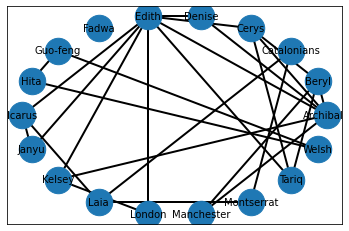

In [19]:
social_network_positions = nx.circular_layout(social_network)  # Define positions for nodes according to a circular layout

nx.draw_networkx_nodes(social_network, social_network_positions, # draw nodes according to position, size
                       node_size=700) 
nx.draw_networkx_edges(social_network, social_network_positions,  # draw edges according to position, line width                      
                       width=2)      
nx.draw_networkx_labels(social_network, social_network_positions,  # draw labels according to position, font choices
                        font_size=10, font_family='sans-serif')
plt.show()                                                        # show the network as drawn

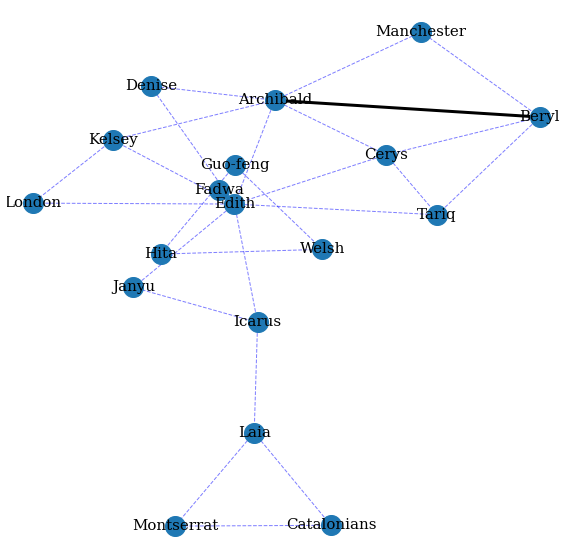

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

weighted_pos = nx.kamada_kawai_layout(social_network_weighted)   # Define positions for force directed node layout

elarge = [(u, v) for (u, v, d) in social_network_weighted.edges(data=True) if d['weight'] > 2] #define a 'heavy edge' style
esmall = [(u, v) for (u, v, d) in social_network_weighted.edges(data=True) if d['weight'] <= 2] # and a 'light edge' style
# nodes
nx.draw_networkx_nodes(social_network_weighted, weighted_pos, node_size=400)                    # draw the nodes

# edges
nx.draw_networkx_edges(social_network_weighted, weighted_pos, edgelist=elarge,                 #draw the heavy edges
                       width=3)
nx.draw_networkx_edges(social_network_weighted, weighted_pos, edgelist=esmall,                 #draw the light edges   
                       width=1, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(social_network_weighted, weighted_pos, font_size=15, font_family='serif')

plt.axis('off')
figure = plt.show()

## Conclusions

Hopefully, this will give you some ideas about what to do with the NLP processes that you have put your corpus through. There is clear value there, related to which things occur together. Different kinds of processing might help you get directed graphs (although that would take some clever classification relating to subjects, objects, etc. ). 

Please do feel free to start back at the beginning, adding more sentences with the same names or even with new names. 

As before, these exercises and this sample code should highlight to you that you need to think about:
- your research questions and what you want to show, explore or understand, 
- your data, texts, corpus, or other research materials to analyse etc. 
- how your processes are related to your reserch questions, and 
- how your processes and data can be made available and reproducible. 

## Further reading

Books, tutorials, package recommendations, etc. for Python

- Natural Language Processing with Python by Steven Bird, Ewan Klein and Edward Loper, http://www.nltk.org/book/
- Foundations of Statistical Natural Language Processing by Christopher Manning and Hinrich Schütze, https://nlp.stanford.edu/fsnlp/promo/
- Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics and Speech Recognition by Dan Jurafsky and James H. Martin, https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf
- Deep Learning in Natural Language Processing by Li Deng, Yang Liu, https://lidengsite.wordpress.com/book-chapters/
- Sentiment Analysis data sets https://blog.cambridgespark.com/50-free-machine-learning-datasets-sentiment-analysis-b9388f79c124

NLTK options
- nltk.corpus http://www.nltk.org/howto/corpus.html
- Data Camp tutorial on sentiment analysis with nltk https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python
- Vader sentiment analysis script available on github (nltk) https://www.nltk.org/_modules/nltk/sentiment/vader.html
- TextBlob https://textblob.readthedocs.io/en/dev/
- Flair, a NLP script available on github https://github.com/flairNLP/flair

networkx
- package details https://networkx.github.io/documentation/stable/index.html
- info about drawing graphs, including links to dedicated graph visualisation software https://networkx.github.io/documentation/stable/reference/drawing.html
- drawing examples and specific tutorials https://networkx.github.io/documentation/latest/auto_examples/index.html
- All the graph measures you can ask for https://networkx.github.io/documentation/stable/reference/algorithms/index.html


Books and package recommendations for R
- Quanteda, an R package for text analysis https://quanteda.io/​
- Text Mining with R, a free online book https://www.tidytextmining.com/​